# Object Detector Model Inference

This notebook will allow you to produce predictions (detected headings, paragraphs, footnotes) based on the trained object detection model

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torchvision
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from util import (
    get_model_instance_segmentation,
    collate_fn,
    get_test_transform,
    myOwnTestDataset,
    format_prediction_string
)
import config

# Load Dependencies (Test Data, Device, Model)

In [2]:
# create test Dataset
test_dataset = myOwnTestDataset(root=config.test_data_dir, 
                                annotation=config.test_coco,
                                transforms=get_test_transform()
                                )

# DataLoader for Test Data
test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.test_batch_size,
    shuffle=config.test_shuffle_dl,
    num_workers=config.num_workers_dl,
    collate_fn=collate_fn
)

# select device (whether GPU or CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load the trained model
model = get_model_instance_segmentation(config.num_classes)
model.load_state_dict(torch.load('./model.pth'))
# put the model in evaluation mode
model.eval()
model.to(device)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

# Collect Predictions

In [3]:
detection_threshold = 0.3
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        #boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        #boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores),
            'image': image,
            'boxes': boxes
        }
        results.append(result)

# How many predictions

In [4]:
len(results)

31

# Sample predictions

In [5]:
results[0:1]

[{'image_id': tensor([1]),
  'PredictionString': '0.3566 223 1154 1622 1436 0.3553 228 742 1626 949 0.3472 209 826 1592 1044 0.3393 214 976 1602 1191 0.3354 214 248 1628 426 0.3132 831 667 1504 1236 0.3094 207 319 1572 502 0.3050 297 669 976 1227',
  'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.]

# Plot sample prediction

In [6]:
idx = 0
sample = results[idx]['image'].permute(1,2,0).cpu().numpy()
boxes = results[idx]['boxes']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


223 1154 1622 1436
228 742 1626 949
209 826 1592 1044
214 976 1602 1191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


214 248 1628 426
831 667 1504 1236
207 319 1572 502
297 669 976 1227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


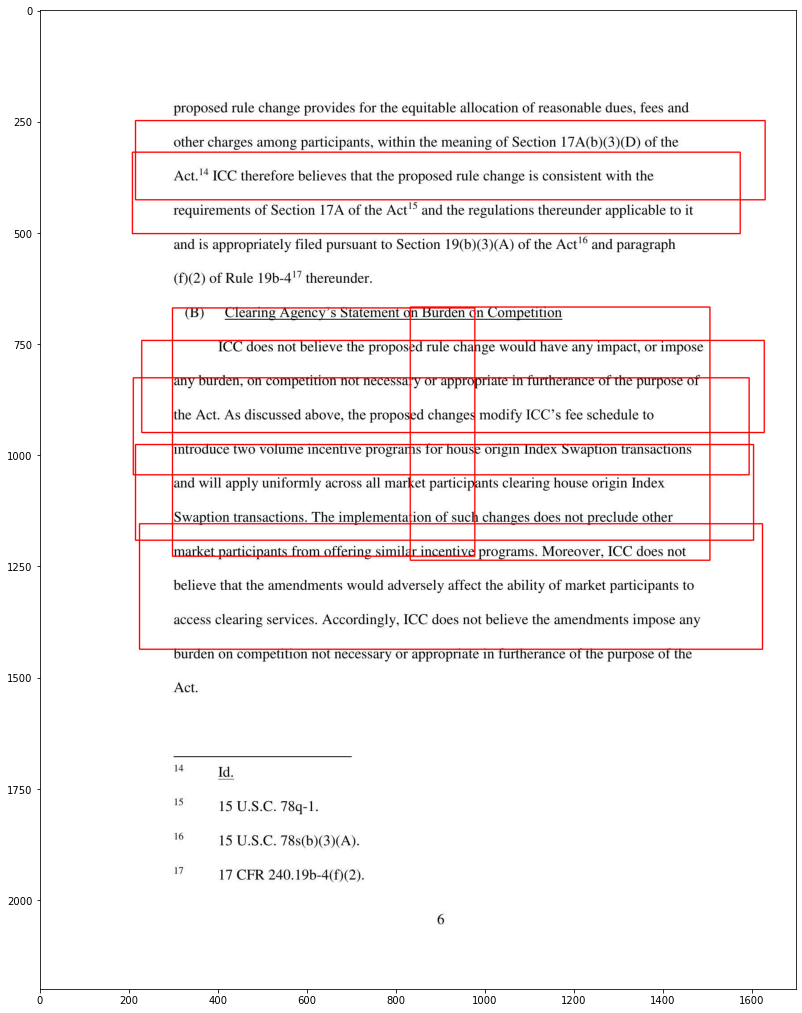

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(26, 18))
color = np.random.randint(0, 256, 3, dtype=np.uint8)

for box in boxes:
    print(box[0], box[1], box[2], box[3])
    # Start coordinate,
    # represents the top left corner of rectangle
    start_point = (box[0], box[1])
    # Ending coordinate,
    # represents the bottom right corner of rectangle
    end_point = (box[2], box[3])
    # Blue color in BGR
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2

    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    sample = cv2.rectangle(sample, start_point, end_point, color, thickness)
    #ax.set_axis_off()
    ax.imshow(sample)